In [1]:
import keras
keras.__version__

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
import sys
print (sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import os, sys

# If using GCP Compute Engine Instance, move images stored in Google Cloud Storage to the local Compute Instance 
#RC: TO-DO: add a line that first checks to make sure these images don't already exist. 
#os.system('gsutil cp -r gs://architecture-styles/ .')

# Using a pre-trained convnet

This notebook contains the code sample found in Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [42]:
# set base dir

# if using local machine: 
#base_dir = '/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/'

# if using a GCP instance: 
base_dir = '/home/rchase/Masters_Thesis'

# sub-dirs for model_weights and trained_models
model_weights_dir = base_dir +'/model_weights/'
trained_models_dir = base_dir + '/trained_models/'

# local:
# trained_weights_dir = os.path.join(base_dir, 'github_repo/Masters_Thesis/model_weights/')
#GCP: 
# trained_weights_dir = os.path.join(base_dir, '/model_weights/')

In [55]:
pwd

'/home/rchase/Masters_Thesis/keras-deep-learning-with-python-notebooks'

In [5]:
# import packages
import numpy as np
import os, sys
from glob import glob
from shutil import copyfile

import matplotlib.pyplot as plt

In [56]:
valid_dir_to_pull_from = 'victorians'

valid_dir_for_class = os.path.join(base_dir, 'Images/architecture_styles/valid/' + valid_dir_to_pull_from + '/')

# glob requires that the directory be changed to the relevant dir.  
# See: http://www.martinbroadhurst.com/listing-all-files-in-a-directory-with-a-certain-extension-in-python.html
pre_glob_working_dir = os.getcwd()

os.chdir(valid_dir_for_class)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rchase/Masters_Thesis/Images/architecture_styles/valid/victorians/'

In [75]:
"""
# code to copy some files to from validation dir to test dir

# RC: should these be completely unseen/held out vs. being copying from valid? Even though valid isn't used to train...)

# chose validation directory to copy images from into test
# i.e. 'Denver_Squares', 'victorians', or 'contemporary'
valid_dir_to_pull_from = 'Denver_Squares'

valid_dir_for_class = os.path.join(base_dir, 'Images/architecture_styles/valid/' + valid_dir_to_pull_from + '/')

# glob requires that the directory be changed to the relevant dir.  
# See: http://www.martinbroadhurst.com/listing-all-files-in-a-directory-with-a-certain-extension-in-python.html
pre_glob_working_dir = os.getcwd()

os.chdir(valid_dir_for_class)

# check that dir was changed as expected
# os.getcwd()

# match files in the current working directory that have .jpg file extensions
g = glob('*.jpg')

# create a random permutation so that the images are chosen in a random order
shuf = np.random.permutation(g)

for i in range(20): copyfile(valid_dir_for_class + shuf[i], base_dir+'/Images/architecture_styles/test/hidden_classes/' + shuf[i])

# chane the directory back to what it was previously
os.chdir(pre_glob_working_dir)
""""""

In [62]:
# import the VGG16 pretrained model
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  # do not include the top, fully-connected Dense layers (there are 3 fully-connected layers in VGG16)
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [63]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [69]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
 
train_dir = os.path.join(base_dir, 'Images/architecture_styles/train/')
validation_dir = os.path.join(base_dir, 'Images/architecture_styles/valid/')
test_dir = os.path.join(base_dir, 'Images/architecture_styles/test/')

In [113]:
# scale images, resize them, and run images through the pre-trained VGG16 model so that features can be extracted

# scale images
datagen = ImageDataGenerator(rescale=1./255)

# specify batch size
batch_size = 20

# extract features of my images using the VGG16 pre-trained model
def extract_features(directory, sample_count):
    # the output of VGG16's convolutional base produces filter maps of shape (sample_count, 4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # make the shape of the second dimension of the label array 3 to account for our three classes
    labels = np.zeros(shape=(sample_count,3))
    # use flow_from_directory to take images from the training directory, re-size them, and create batches
    generator = datagen.flow_from_directory( 
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        # RC: set class_mode=categorical for 2D one-hot encoded labels (best for multi-class, as opposed to binary, sparse labels, etc.) 
        # https://keras.io/preprocessing/image/
        class_mode='categorical')
    # define the label map outside of the function
    global label_map 
    global test_images_label_map
    # populate label map (if class_mode='categorical' this will be our 2D one-hot encoded array)
    # because I did not group the test images into separate directories for each class, I'm creating a separate label_map for these.
    if directory[-5:-1]=='test':
        test_images_label_map = generator.class_indices
    else: 
        label_map = generator.class_indices
    # Because we later want to be able to print the original image for the test set setting a condition for the test set to create a 
    # separate array for RC_raw_test_images
    if directory[-5:-1]=='test':
        # creating an array for the the raw test images to flow into - the dimensions of each of the images will be 150 x 150. 
        RC_raw_test_images = np.zeros(shape=(sample_count, 150, 150, 3))
        
    
    i = 0
    for inputs_batch, labels_batch in generator:
        #print(type(inputs_batch[0]))
        # print(inputs_batch)
        
        #RC: first I'm saving the raw images
        if directory[-5:-1]=='test':
            RC_raw_test_images[i * batch_size : (i + 1) * batch_size] = inputs_batch
        
        # use the .predict method to extract the features from the pre-trained model "conv_base"
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # print(type(features_batch))
        # print(features_batch)
        # save the result in the array we created above
        #RC:REVIEW!
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        # print(features.shape)
        # print(type(features))
        # print(labels_batch.shape)
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we `break` after every image has been seen once.
            break
    if directory[-5:-1]=='test':
        return features, labels #, RC_raw_test_images
    else: 
        return features, labels


train_features, train_labels = extract_features(train_dir, 820)
validation_features, validation_labels = extract_features(validation_dir, 100)
#test_features, test_labels, RC_raw_test_images  = extract_features(test_dir, 60)
test_features, test_labels  = extract_features(test_dir, 60)

Found 820 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 60 images belonging to 1 classes.


In [66]:
#RC_raw_test_images.shape

In [ ]:
# Here is the input image array
# check to make sure that it is created as expected. 
# for example, each image and specific pixel placement has three corresponding RGB values
# RC_raw_test_images_to_print[3,125,125,]

In [81]:
# make sure the labels shape looks right
train_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [82]:
# print the shape of the validation label array 
validation_labels.shape

(100, 3)

In [83]:
# print the labels_map
label_map

{'Denver_Squares': 0, 'contemporary': 1, 'victorians': 2}

In [84]:
# print the labels_map associated with the test set
#test_images_label_map

In [114]:
# print the shape of the extracted features (feature maps)
train_features.shape

(820, 4, 4, 512)

In [86]:
validation_features.shape

(100, 4, 4, 512)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [115]:
test_features.shape

(60, 4, 4, 512)

In [117]:
# flatten the features corresponding to each image before using them as an input to the fully-connected classifier 
train_features = np.reshape(train_features, (820, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (100, 4 * 4 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (60, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [118]:
# Build a small network with a finally, fully-connected, dense layer 
# we'll pass our extracted features through these dense layers
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
#RC where does the 256 come from?? I know it's the number of hidden units but is it specific to something?
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
# set the first argument of layers.Dense so that it outputs probabilities for three classes
model.add(layers.Dense(3, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              # set the loss='categorical_crossentropy' if my labels are one-hot coded (i.e. if class_mode=categorical in datagen)
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 820 samples, validate on 100 samples
Epoch 1/30
820/820 [==============================] - 1s 655us/step - loss: 1.0006 - acc: 0.5354 - val_loss: 0.8036 - val_acc: 0.6500
Epoch 2/30
820/820 [==============================] - 0s 293us/step - loss: 0.8260 - acc: 0.6427 - val_loss: 0.6638 - val_acc: 0.7900
Epoch 3/30
820/820 [==============================] - 0s 296us/step - loss: 0.7100 - acc: 0.7073 - val_loss: 0.5486 - val_acc: 0.8700
Epoch 4/30
820/820 [==============================] - 0s 292us/step - loss: 0.5815 - acc: 0.7976 - val_loss: 0.4827 - val_acc: 0.8900
Epoch 5/30
820/820 [==============================] - 0s 290us/step - loss: 0.5188 - acc: 0.8098 - val_loss: 0.4454 - val_acc: 0.8500
Epoch 6/30
820/820 [==============================] - 0s 289us/step - loss: 0.4479 - acc: 0.8463 - val_loss: 0.4012 - val_acc: 0.9100
Epoch 7/30
820/820 [==============================] - 0s 290us/step - loss: 0.3958 - acc: 0.8768 - val_loss: 0.3749 - val_acc: 0.8900
Epoch 8/30
820/8

In [119]:
# print the full model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

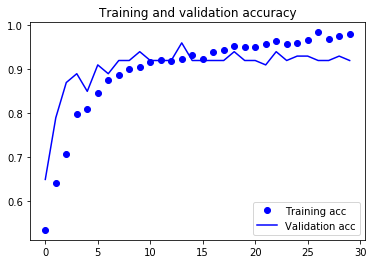

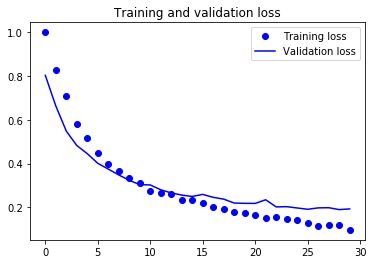

In [120]:
# print the model results: 

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Practice saving model weights, then re-building the model

In [121]:
# save model weights

# save to local machine 
#model.save_weights('/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/github_repo/Masters_Thesis/model_weights/'+'weights_for_vgg_model_with_new_fully_connected_layer')

# Save to Compute Engine instance on GCP (can also copy these to a Google Cloud Storage bucket if desired) 
model.save_weights(base_dir + '/model_weights/'+'weights_for_vgg_model_with_new_fully_connected_layer')

In [122]:
# Now I want to print my predictions

# first we'll need to pipe a new image through the conv_base to get the features which are inputs to the model 
# Note that the shape is also important since the last layer of the conv_base block5_pool produces an output 
# of shape (None, 4, 4, 512).  Then we'll actually flatten this to a two-dimensional array of shape: (None, 4 * 4 * 512)) 
# which will be the input for the first fully connected layer. 

# https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

 
# RC: I needed to find out what shape the argument to conv_base.predict() is.  This is inputs_batch which are the 
# elements of the generator.  I needed this to supply my test images to the conv_base.predict() in the same fashion 
# as previously so that they could run through the base model and output the feature weights which I need to then 
# supply to my new fully connected model.  It turns out that inputs_batch in the generator from flow_from_directory 
# is a 2 dimensional tuple.  Both the first and second elements (0 and 1 indexed items) are ndarrays.  
# The shape of the first ndarray is (1, 150, 150, 3) - this is our image array.  The shape of the second ndarray is:
# (1,1), where the first element is just: [1.], and the second element is nothing.  

In [123]:
# To load the model again (in case this is the starting point) we can re-build our existing model using the saved weights: 
# (alternatively we could have saved the entire model and just re-loaded the model.  This is the approach we'll take later 
# when we do fine_tuning)

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

# function to rebuild the model:
def rebuild_my_model():
    model = models.Sequential()
    #RC: where does the 256 come from? I know it's the number of hidden units but is it specific to something?
    model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    model.add(layers.Dropout(0.5))
    #RC: changed the below so that the dense layer outputs probabilities for three classes
    #RC: changed activation='sigmoid' to activation='softmax'
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    # change the loss to categorical_crossentropy for my multi-class problem
    loss='categorical_crossentropy',
    metrics=['acc'])
    return model

In [124]:
# save the small, three layer classifier model as "model"
model = rebuild_my_model()

In [125]:
# print model object
print(model)

In [126]:
# the model is only the 3 layer classifier that we built on top of the VGG16 conv_base
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


In [127]:
# load the model weights.  Alternatively, rather than rebuilding the model, I could have just saved off the model
# and reladed it

model.load_weights(model_weights_dir + 'weights_for_vgg_model_with_new_fully_connected_layer')

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


In [129]:
# RC: now, if we want to run a prediction on this model we'd have to pipe it throught the imageDataGenerator again. 
# this will convert the test image to the size we need for the conv_base (150 x 150)
# and also pipe it through the convolutional base
# extract_features(directory, sample_count)

# we'd also want to reshape/flatten the output of the conv_base so that it's the right input shape for our fully connected model

# flatten my feature tensor 
# RC:  to flatten this out in order to use model.predict?  In 3.4.5 Chollet just feeds x_test to predict and xtest wasn't flattened... 
img_tensor = np.reshape(test_features, (1, 4 * 4 * 512))

In [130]:
#img_tensor.shape

(60, 8192)

In [106]:
#label_map

{'Denver_Squares': 0, 'contemporary': 1, 'victorians': 2}

In [132]:
#print(features_batch)
#print(features_batch.shape)

#RC: use our model containing the fully connected dense classification layer to serve our predictions
#model.predict(re_shaped_img_tensor)


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this 
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you 
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

In [ ]:
# At this point since we're using data augmentation, I switched to using a Compute Engine instance on GCP with an NVIDIA K80 GPU.  
# I followed the very helpful instructions provided by Stanford's CS231n course: http://cs231n.github.io/gce-tutorial/

In [133]:
# use the Sequential class to add the fully-connected model to the conv_base  
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# the 3 corresponds to the three output classes
model.add(layers.Dense(3, activation='sigmoid'))

This is what our model looks like now:

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [41]:
# RC: this must be the number of filters (NOT the actual number of parameters - i.e. weights contained in the filter) 
# In the next section it gets reduced to 4 (2 convoluaional layers with 2 biases each)
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [42]:
conv_base.trainable = False

In [43]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [44]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should NOT be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      # RC: now that we're augmenting the data, we don't need to be careful about feeding the same image to the 
      # trainig model more than once per epoch. Therefore, we can choose the number of batches we want and it doesn't 
      # have to be computed via (number of training images)/(batch_size)
      # RC: is the above statement correct per keras documentation: 
      # steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch 
      # finished and starting the next epoch. It should typically be equal to the number of samples of your dataset divided 
      # by the batch size.  https://keras.io/models/sequential/ 
      steps_per_epoch=100, 
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 820 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Epoch 1/30
 - 56s - loss: 0.9047 - acc: 0.6065 - val_loss: 0.6841 - val_acc: 0.7200
Epoch 2/30
 - 52s - loss: 0.6877 - acc: 0.7450 - val_loss: 0.5601 - val_acc: 0.8000
Epoch 3/30
 - 55s - loss: 0.6084 - acc: 0.7530 - val_loss: 0.4948 - val_acc: 0.8100
Epoch 4/30
 - 52s - loss: 0.5578 - acc: 0.7880 - val_loss: 0.4508 - val_acc: 0.8500
Epoch 5/30
 - 53s - loss: 0.5222 - acc: 0.8025 - val_loss: 0.4298 - val_acc: 0.8300
Epoch 6/30
 - 53s - loss: 0.4896 - acc: 0.8185 - val_loss: 0.4205 - val_acc: 0.8300
Epoch 7/30
 - 52s - loss: 0.4791 - acc: 0.8185 - val_loss: 0.3784 - val_acc: 0.8700
Epoch 8/30
 - 52s - loss: 0.4585 - acc: 0.8145 - val_loss: 0.3760 - val_acc: 0.8600
Epoch 9/30
 - 52s - loss: 0.4181 - acc: 0.8495 - val_loss: 0.3461 - val_acc: 0.8700
Epoch 10/30
 - 56s - loss: 0.4069 - acc: 0.8515 - val_loss: 0.3334 - val_acc: 0.8900
Epoch 11/30
 - 52s - loss: 0.4006 - acc: 0.8510 - val_loss: 0.3182 - val_acc:

In [45]:
model.save(trained_models_dir + 'Feature_extraction_with_data_augmentation.h5')

Let's plot our results again:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [80]:
# RC: In the event that this is our starting point, below is the code to reload the model
model = load_model(trained_models_dir + 'Feature_extraction_with_data_augmentation.h5')

NameError: name 'load_model' is not defined

In [45]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [46]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 56s 562ms/step - loss: 0.2832 - acc: 0.8955 - val_loss: 0.2244 - val_acc: 0.9200
Epoch 2/100
100/100 [==============================] - 52s 524ms/step - loss: 0.2035 - acc: 0.9220 - val_loss: 0.1683 - val_acc: 0.9400
Epoch 3/100
100/100 [==============================] - 55s 549ms/step - loss: 0.1770 - acc: 0.9335 - val_loss: 0.2006 - val_acc: 0.9400
Epoch 4/100
100/100 [==============================] - 53s 525ms/step - loss: 0.1879 - acc: 0.9300 - val_loss: 0.1667 - val_acc: 0.9400
Epoch 5/100
100/100 [==============================] - 54s 543ms/step - loss: 0.1734 - acc: 0.9335 - val_loss: 0.1755 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 52s 522ms/step - loss: 0.1309 - acc: 0.9505 - val_loss: 0.1205 - val_acc: 0.9500
Epoch 7/100
100/100 [==============================] - 53s 526ms/step - loss: 0.1283 - acc: 0.9550 - val_loss: 0.1343 - val_acc: 0.9400
Epoch 8/100
100/100 [===========================

KeyboardInterrupt: 

In [ ]:
model.save('fine_tuned_model.h5')

In [ ]:
# copy the saved model to Google Cloud Storage
os.system('gsutil cp -r fine_tuned_model.h5 gs://architecture-style-trained-models/')

Let's plot our results using the same plotting code as before:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [71]:
# load the trained fine_tuned_model (in case this becomes our starting point for serving predictions) 

# if on GCP, copy trained model from GCS to Compute Engine instance
#os.system('gsutil cp -r gs://architecture-style-trained-models/fine_tuned_model.h5' + ' ' + base_dir + '/trained_models/')

model = keras.models.load_model(trained_models_dir + 'fine_tuned_model.h5')

In [8]:
# check to makes sure we have a Sequential model object
model

In [72]:
# view the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


In [118]:
#count the number of test unlabeled test images
test_batch_size = len(os.listdir(os.path.join(test_dir + '/hidden_classes/')))

# RC: not sure what .DS_Store is.  Regardless if there are fewer images in the dir than what I specify as the 
# batch_size parameter in .flow_from_directory, it will just take the number of images in the directory. 
#os.listdir(os.path.join(test_dir + '/hidden_classes/'))

In [116]:
# scale pixel colors
test_datagen = ImageDataGenerator(rescale=1./255)

# convert images to size 150 x 150 pixels
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=test_batch_size,
        class_mode='categorical')
        
# test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

Found 21 images belonging to 1 classes.


In [120]:
# get a batch of image arrays and labels (note that we put all the test images in a single dir. 
# therefore, the labels are meaningless 
imgs,labels = next(test_generator)

In [122]:
# look at the shape to make sure it's as expected 
imgs.shape

(21, 150, 150, 3)

In [123]:
# print the predicted classes 
print(model.predict_classes(imgs))
predicted_class=model.predict_classes(imgs)

[1 1 2 0 2 1 0 0 2 1 1 1 2 0 0 0 1 2 0 2 1]


In [124]:
# print the probabilites of each class
print(model.predict(imgs))
preds = model.predict(imgs)

[[5.3617271e-09 1.0000000e+00 1.1520674e-18]
 [7.4639045e-22 1.0000000e+00 4.4179174e-22]
 [7.3533284e-27 3.7520103e-31 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 3.5009797e-25]
 [1.5891622e-23 1.5902655e-31 1.0000000e+00]
 [4.3961779e-23 1.0000000e+00 7.4860565e-23]
 [1.0000000e+00 2.2635784e-17 1.6794446e-15]
 [1.0000000e+00 4.4410088e-25 1.3352573e-14]
 [6.7019098e-24 3.0521556e-31 1.0000000e+00]
 [3.7452181e-16 1.0000000e+00 1.1161169e-15]
 [3.6060400e-03 9.9502558e-01 1.3683911e-03]
 [9.2284028e-23 1.0000000e+00 5.8827599e-15]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 9.0610067e-21 1.8719631e-22]
 [1.0000000e+00 1.2184858e-30 1.7566059e-18]
 [1.0000000e+00 1.1609892e-31 1.4367381e-11]
 [1.5115971e-21 1.0000000e+00 3.6939968e-23]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.7166767e-37 2.9982533e-23]
 [2.0398508e-35 0.0000000e+00 1.0000000e+00]
 [3.9098239e-20 1.0000000e+00 3.8340597e-10]]


In [125]:
# function to display the actual label names
image_number=0

# using the info from the class_indicies dictionary from .flow_from_directory (Keras' ImageDataGenerator class) 
# during initial training      
while image_number < test_batch_size-1:
    if predicted_class[image_number] == 0:
        prediction = 'Denver_Square'
    elif predicted_class[image_number] == 1:
        prediction = 'contemporary'
    elif predicted_class[image_number] == 2: 
        prediction = 'victorian'
    print(prediction)

    image_number += 1

contemporary
contemporary
victorian
Denver_Square
victorian
contemporary
Denver_Square
Denver_Square
victorian
contemporary
contemporary
contemporary
victorian
Denver_Square
Denver_Square
Denver_Square
contemporary
victorian
Denver_Square
victorian
contemporary


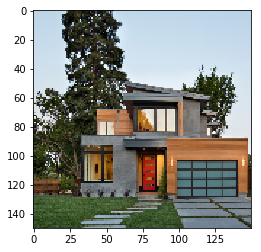

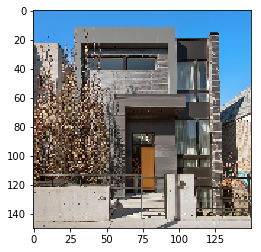

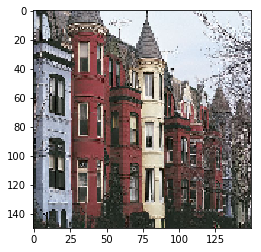

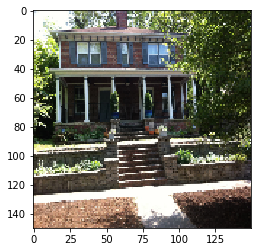

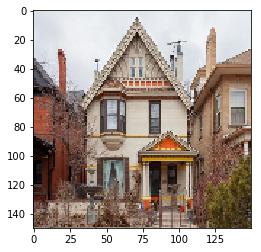

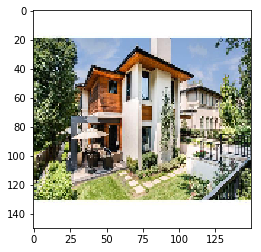

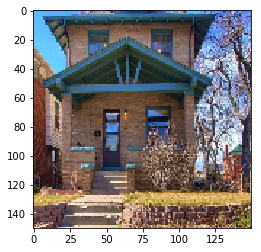

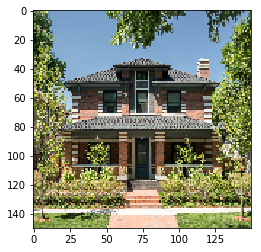

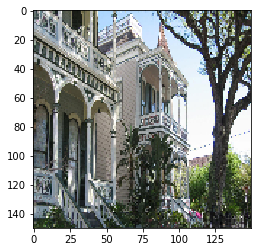

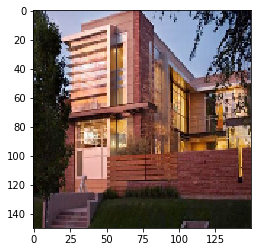

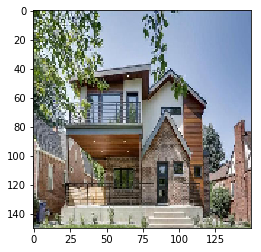

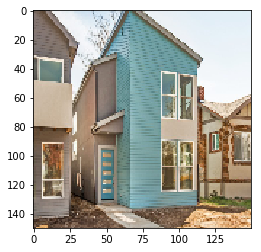

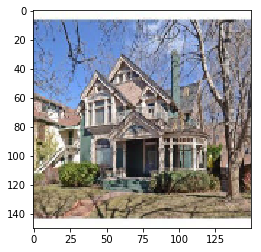

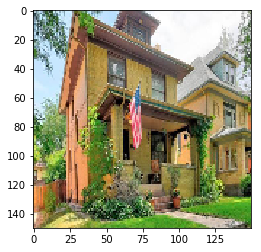

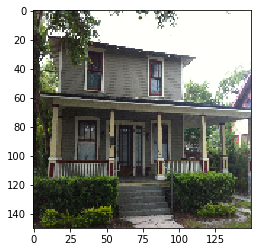

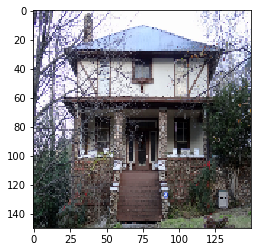

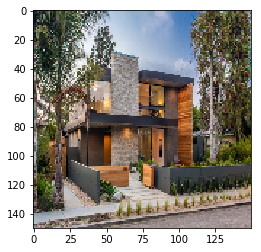

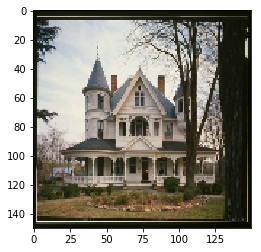

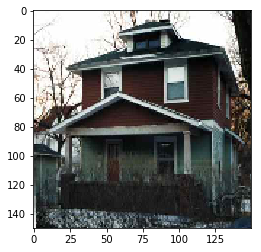

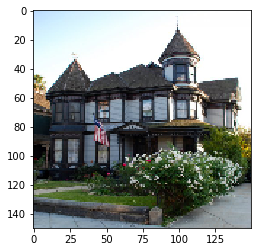

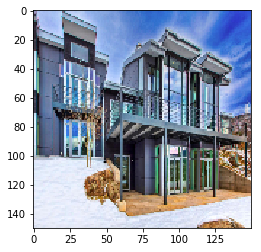

In [132]:
# show the corresponding images to confirm predictions
image_number = 0
# RC: I had to add -1 because I'm not sure what the .DS_Store is in the test dir
while image_number < test_batch_size - 1: 
    plt.imshow(imgs[image_number])
    plt.show()
    image_number += 1

In [141]:
# RC: the decode_predicitons function for decoding predictions and giving classes to them may only work 
# for ImageNet since it expects a 2d array of predicitons of shape (samples, 1000), and the ImageNet competition 
# predicts 1000 classes

#from keras.applications.vgg16 import decode_predictions

#y_pred = model.predict(imgs)
#decode_predictions(y_pred)

In [ ]:
# pick a random image from the directory 
random_test_image_index = np.random.randint(0,len(os.listdir(test_dir + 'hidden_classes/')))

random_test_image_name = os.listdir(test_dir + 'hidden_classes/')[random_test_image_index]

# load random image
from keras.preprocessing import image 
#RC: this can be shown as an image as-is (without using plt.imgshow and first making it an array)
random_test_image = image.load_img(os.path.join(test_dir + 'hidden_classes/' + random_test_image_name), target_size=(150, 150))

# convert to an array
random_test_image_tensor = image.img_to_array(random_test_image)

random_test_image_tensor= np.expand_dims(random_test_image_tensor, axis=0)
random_test_image_tensor /=255.

# check the shape of the loaded tensor
# random_test_image_tensor.shape

# show the image 
#if show: 
plt.imshow(random_test_image_tensor[0])
plt.axis('off')
plt.show()
    
# load the model
model = keras.models.load_model(trained_models_dir + 'fine_tuned_model.h5')

# make prediction 
pred = model.predict(random_test_image_tensor)
#print(pred)

# find the highest prediction
idx = np.argmax(pred, axis=1)

# print the probability associated with the most probable class
print ('  {:.4f}'.format(pred[0, idx[0]]))

# display label name

# first print classes
predicted_class = model.predict_classes(random_test_image_tensor)
# using the info from the class_indicies dictionary from .flow_from_directory (Keras' ImageDataGenerator class) 
# during initial training      
if predicted_class == 0:
    prediction = 'Denver_Square'
elif predicted_class== 1:
    prediction = 'contemporary'
elif predicted_class == 2: 
    prediction = 'victorian'
print(prediction)

# as a next step, I may want to wrap everything in this call into a single function to serve one prediction at a time (preparing for deployment to mobile)

In [54]:
# RC: all snippets below this are from fast.ai's deeplearning1 course, however, they aren't working for me...

#RC this is "ground truth" view from the fast.ai deeplearning1 course: 
# ...it depends on your images being in labeled directories, however this is not ultimately what I want.  
# still, the way the output is formatted looks nice

#def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
def plots(ims, figsize=(150,150), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



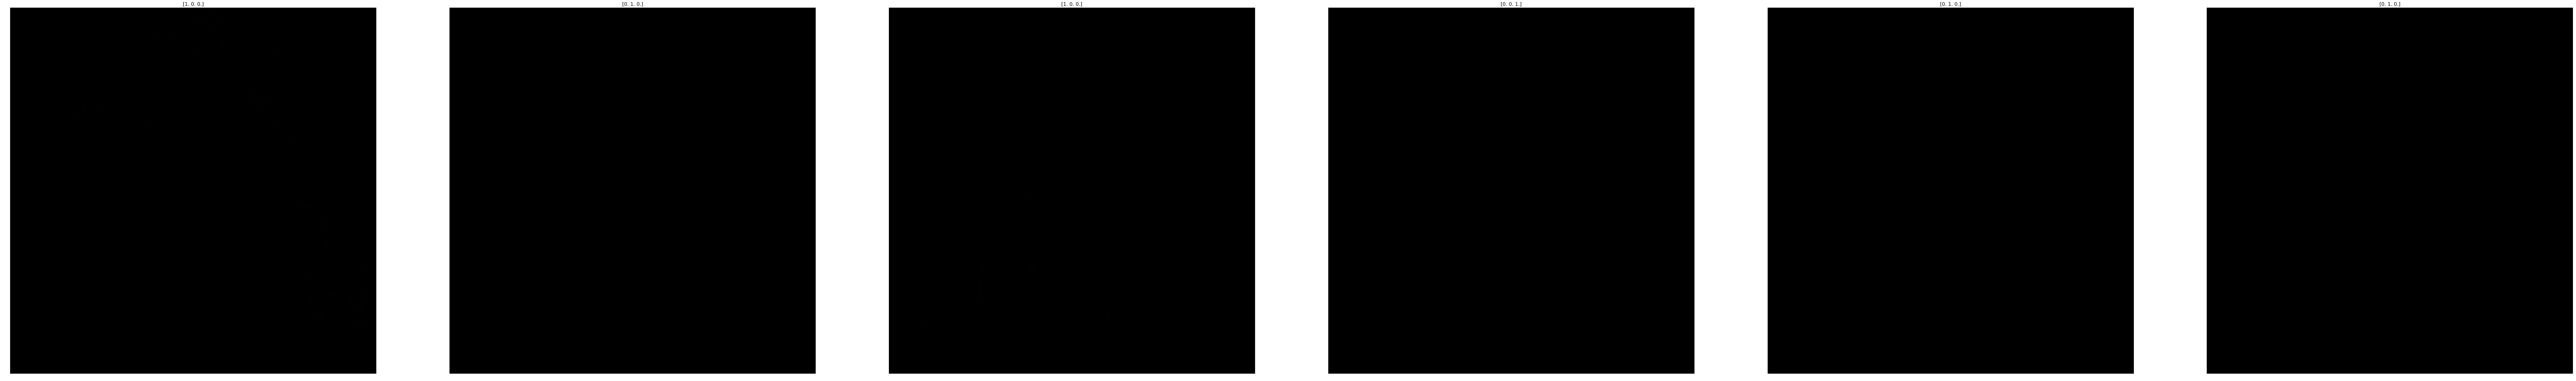

In [55]:
plots(imgs, titles=labels)

In [110]:
# from fast.ai 
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [111]:
# from fast.ai
pred_batch(imgs)

Shape: (6, 3)


NameError: name 'classes' is not defined

In [109]:
# from fast.ai
model.predict(imgs)

AttributeError: 'numpy.ndarray' object has no attribute 'format'


Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.

### Visualizing What ConvNets Learn

In [12]:
random_test_image_index = np.random.randint(0,len(os.listdir(test_dir + 'hidden_classes/')))

random_test_image_name = os.listdir(test_dir + 'hidden_classes/')[random_test_image_index]

# load random image
from keras.preprocessing import image 
#RC: this can be shown as an image as-is (without using plt.imgshow and first making it an array)
random_test_image = image.load_img(os.path.join(test_dir + 'hidden_classes/' + random_test_image_name), target_size=(150, 150))

# convert to an array
random_test_image_tensor = image.img_to_array(random_test_image)


random_test_image_tensor= np.expand_dims(random_test_image_tensor, axis=0)
random_test_image_tensor /=255.

print(random_test_image_tensor.shape)

(1, 150, 150, 3)


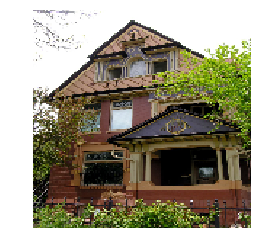

In [13]:
# check the shape of the loaded tensor
# random_test_image_tensor.shape

# show the image 
#if show: 
plt.imshow(random_test_image_tensor[0])
plt.axis('off')
plt.show()

In [15]:
# This example from section 5.4.1 depends on using the cats-vs-dogs classification model that we trained in section 5.2
# RC: ignore this for now and jump to 5.4.2 instead 
#from keras import models
#model.layers[:8]
#layer_outputs = [layer.output for layer in model.layers[:8]]
#activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


# 5.4.2

In [10]:
# load the trained fine_tuned_model (in case this becomes our starting point for serving predictions) 

# if on GCP, copy trained model from GCS to Compute Engine instance
#os.system('gsutil cp -r gs://architecture-style-trained-models/fine_tuned_model.h5' + ' ' + base_dir + '/trained_models/')

model = keras.models.load_model(trained_models_dir + 'fine_tuned_model.h5')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.input[0]

<tf.Tensor 'strided_slice_2:0' shape=(150, 150, 3) dtype=float32>

In [35]:
model.get_layer(my_Model_object).get_layer('input').input[0]

<tf.Tensor 'strided_slice_3:0' shape=(37, 37, 128) dtype=float32>

In [38]:
model.get_layer(my_Model_object).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [12]:
from keras.applications import VGG16
from keras import backend as K

my_Model_object = 'vgg16'
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(my_Model_object).get_layer(layer_name).output
# RC: why do we find the mean here? 
loss = K.mean(layer_output[:, :, :, filter_index])

In [27]:
#layer_output[:, :, :, filter_index]

<tf.Tensor 'strided_slice_1:0' shape=(?, 37, 37) dtype=float32>

In [26]:
layer_output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, 37, 37, 256) dtype=float32>

In [29]:
print(loss)
type(loss)

Tensor("Mean:0", shape=(), dtype=float32)


tensorflow.python.framework.ops.Tensor

In [30]:
print(model.input)
type (model.input)

Tensor("vgg16_input:0", shape=(?, 150, 150, 3), dtype=float32)


tensorflow.python.framework.ops.Tensor

In [41]:
# this seems to work which is odd because model.input, and model.get_layer(my_Model_object).get_layer('input_1').input seem inditinguishable
grads = K.gradients(loss, model.get_layer(my_Model_object).get_layer('input_1').input)[0]

In [52]:
#this and the below are the same, but they operate differently 
model.input[0]

<tf.Tensor 'strided_slice_5:0' shape=(150, 150, 3) dtype=float32>

In [51]:
#this and the above are the same, but they operate differently 
model.get_layer(my_Model_object).get_layer('input_1').input[0]

<tf.Tensor 'strided_slice_4:0' shape=(150, 150, 3) dtype=float32>

In [48]:
type(grads)

tensorflow.python.framework.ops.Tensor

In [43]:
grads

<tf.Tensor 'gradients_4/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, 150, 150, 3) dtype=float32>

In [49]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [54]:
iterate = K.function([model.get_layer(my_Model_object).get_layer('input_1').input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [55]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])

    input_img_data += grads_value * step

In [56]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [72]:
model.get_layer('vgg16').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [68]:
model.input

<tf.Tensor 'vgg16_input:0' shape=(?, 150, 150, 3) dtype=float32>

In [80]:
def generate_pattern(layer_name, filter_index, size=150):
    #RC: I needed to edit this to index into the the nested Model object
    layer_output = model.get_layer('vgg16').get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    #RC: edit this to index in the nested Model object
    grads = K.gradients(loss, model.get_layer('vgg16').get_layer('input_1').input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.get_layer('vgg16').get_layer('input_1').input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

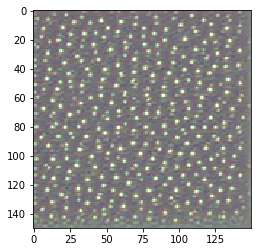

In [81]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

In [85]:
layer_name = 'block1_conv1'
size = 150 #64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
